In [1]:
import numpy as np                                                                        
import matplotlib.pyplot as plt
import pyCloudy as pc
import pyneb as pn
from astropy    import constants as const
from astropy.io import ascii
import pandas as pd
from scipy import interpolate
import warnings
from scipy.integrate import quad, IntegrationWarning
import scipy.integrate as integrate
from numpy import log10, exp
import os
from astropy.constants import c
import astropy.units as u
from scipy import special

kpc = const.kpc.cgs.value

def SB(z, radius_kpc, emissivity, dr):
    r_min, r_max = radius_kpc.min(), radius_kpc.max()
    Project_R = np.linspace(0, 100, 70) * kpc
    N = len(Project_R)
    surface_brightness = np.zeros(N)
    Lumin = np.zeros(N)

    from scipy.interpolate import interp1d
    emis_interp = interp1d(radius_kpc, emissivity, bounds_error=False, fill_value=0)
    
    for ii, R in enumerate(Project_R):
        # 적분 함수 정의
        def integrand(r):
            if r < R:
                return 0
            else:
                emis = emis_interp(r)
                return emis * r / np.sqrt(r**2 - R**2)
            
        surface_brightness[ii], _ = quad(integrand, R, r_max)
        surface_brightness[ii] *= 2 / (1+z)**4
    dR =  Project_R[1] - Project_R[0]    
    def lumin_integrand(R):
        if R == 0 :
            area = np.pi * (0.5*dR)**2
        elif R == r_max:
            area = np.pi * (2*R +0.5*dR)*0.5*dR 
        else:
            area = 2 * np.pi * R * np.interp(R, Project_R, surface_brightness)
        
        return area
    
    Lumin, _ = quad(lumin_integrand, 0, r_max)
    
    return Project_R / kpc, surface_brightness, Lumin

In [2]:
Lum , N_H = 46 , 18

In [5]:

path_way = f'/home/jin/RT/RT_cloudy/L_{Lum}/N_H/CIV_Lumin'
Mod = pc.CloudyModel(path_way, cloudy_version_major=23)
Mod.ionic_names

N_H = sum(Mod.dr*Mod.nH)
# solar_metallicitiy from von Steiger et al. 2016
frac_He = 0.085 #E-01
frac_C = 4.47E-04
frac_O = 6.61E-04
frac_N = 9.33E-05
frac_Mg = 7.08E-05

N_HI = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',0))
N_HII = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',1))
N_HeII = frac_He*sum(Mod.dr*Mod.nH*Mod.get_ionic('He',1))
N_OVI = frac_O*sum(Mod.dr*Mod.nH*Mod.get_ionic('O',5))
N_NV = frac_N*sum(Mod.dr*Mod.nH*Mod.get_ionic('N',4))
N_CIV = frac_C*sum(Mod.dr*Mod.nH*Mod.get_ionic('C',3))

num = len(Mod.nH)
r_CIV = path_way +  '.ele_C'
f = open(r_CIV,'r')
header = f.readline()
CIV_frac = np.zeros(num)
i = 0
for line in f:
    line = line.strip()
    columns = line.split()
    j = float(columns[4])
    CIV_frac[i] = j
    i = i + 1

r_He = path_way +  '.ele_He'
f = open(r_He,'r')
header = f.readline()
HeII_frac = np.zeros(num)
i = 0
for line in f:
    line = line.strip()
    columns = line.split()
    j = float(columns[2])
    HeII_frac[i] = j
    i = i + 1


radius = Mod.radius/kpc
radius_kpc =Mod.radius 
dr = Mod.dr 


n_H= Mod.nH
n_He = n_H*frac_He
n_C = n_H*frac_C
nden_CIV = CIV_frac*n_C
nden_HeII = HeII_frac*n_He


CIV_Lum = float(Mod.get_emis_vol('C__4_154819A')) + float(Mod.get_emis_vol('C__4_155078A'))
CIV_emis = (Mod.get_emis('C__4_154819A')) + (Mod.get_emis('C__4_155078A'))
CIV_den = nden_CIV

Lya_Lum= float(Mod.get_emis_vol('H__1_121567A'))
Lya_emis = Mod.get_emis('H__1_121567A')
Lya_den = n_H

HeII_Lum = float(Mod.get_emis_vol('HE_2_164043A'))
HeII_emis = Mod.get_emis('HE_2_164043A')
HeII_den = nden_HeII




CIV_Column_density = np.sum(dr*CIV_den)
HeII_Column_density = np.sum(dr*HeII_den)
Lya_Column_density = np.sum(dr*Lya_den)

print('CIV_Lum =', CIV_Lum)
print('HeII_Lum =', HeII_Lum)
print('-'*50)
print(f'CIV_Column density = {CIV_Column_density:.2e}')

CIV_Lum = 9.803856233018613e+42
HeII_Lum = 2.86125498939896e+43
--------------------------------------------------
CIV_Column density = 3.41e+15


/tmp/ipykernel_9054/4210825547.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Lumin, _ = quad(lumin_integrand, 0, r_max)
/tmp/ipykernel_9054/4210825547.py:39: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-

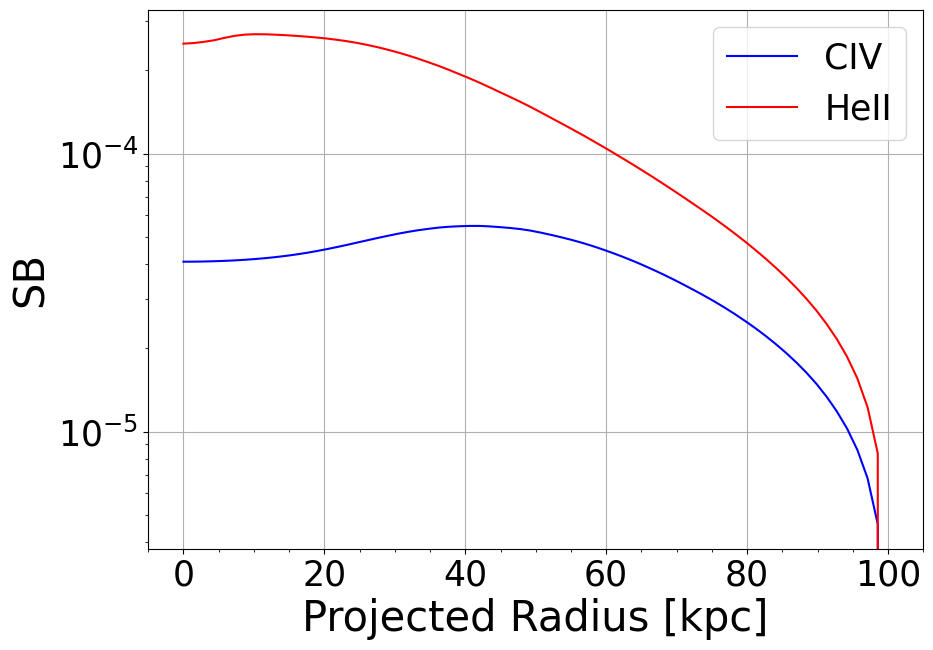

In [4]:
fig = plt.figure(1,figsize=(10,7))

radius_p,SB_CIV,Lumin_CIV = SB(0,radius_kpc,CIV_emis,dr)
radius_p,SB_HeII,Lumin_HeII = SB(0,radius_kpc,HeII_emis,dr)

plt.plot(radius_p, SB_CIV,'b-',label='CIV')
plt.plot(radius_p, SB_HeII,'r-',label='HeII')
plt.yscale('log')
plt.legend(fontsize=25)
plt.xlabel('Projected Radius [kpc]',fontsize=30)
plt.ylabel('SB',fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.minorticks_on()
plt.grid(True)